## step1. 載入訓練資料

In [1]:
import torchvision
from torchvision.io import ImageReadMode
from torchvision import transforms

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import random
import os, glob

TARGET_SIZE = (64, 64)
TRAIN_DIR = "train"
TEST_DIR = "test"

class LazyLoader:
    def __init__(self, base_path=None):
        self.task = list()
        self.done = list()
        self.size = 0
        self.target_size = TARGET_SIZE

        self.t = transforms.Compose([
            transforms.Resize(size=TARGET_SIZE)
        ])

        if not base_path is None:
            for png_path in glob.glob(os.path.join(base_path, "*.png")):
                filename_without_postfix = png_path[:-4]
                base_path = filename_without_postfix
                txt_path = "{}.txt".format(filename_without_postfix)
                self.done.append((png_path, txt_path, base_path))
                self.size += 1

    def reset(self):
        while len(self.task) > 0:
            self.done.append(self.task.pop())

    def split(self, r = 0.1):
        self.reset()

        random.shuffle(self.task)
        split_size = round(r * len(self.done))
        split_buf = self.done[:split_size]
        self.done = self.done[split_size:]
        self.size = len(self.done)

        split_loader = LazyLoader()
        split_loader.done = split_buf
        split_loader.size = len(split_loader.done)
        return split_loader

    def look(self, batches):
        for i in range(batches):
            img, tgt, _ = self.load_data()
            plt.imshow(img.permute(1, 2, 0))
            plt.title("number {}".format(tgt))
            plt.show()

    def load_data(self):
        if len(self.task) == 0:
            self.task, self.done = self.done, self.task
            random.shuffle(self.task)

        query = self.task.pop()
        self.done.append(query)
        png_path, txt_path, base_path = query

        img = torchvision.io.read_image(png_path, mode=ImageReadMode.GRAY)
        img = img.float() / 255.
        img = self.t(img)

        try:
            with open(txt_path, "r") as f:
                tgt = int(f.read().strip().split()[0])
        except:
            tgt = -1

        return img, tgt, base_path

    def sample(self, batches):
        imgs, tgts, paths = list(), list(), list()
        for i in range(batches):
            img, tgt, path = self.load_data()
            imgs.append(img)
            tgts.append(tgt)
            paths.append(path)
        return torch.stack(imgs).float(), torch.as_tensor(tgts).long(), paths

    def __len__(self):
        return self.size

    def __iter__(self):
        self.reset()
        self.iter_index = 0
        return self
        
    def __next__(self):
        imgs, tgts, paths = self.sample(1)
        if self.size > self.iter_index:
            self.iter_index += 1
            return imgs, tgts, paths
        else:
            raise StopIteration

t_loader = LazyLoader(TRAIN_DIR)
v_loader = t_loader.split(0.1)

## step2. 建構神經網路

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.linear = nn.Linear(
            in_size,
            out_size,
            bias=False
        )

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class SqueezeAndExcitation(nn.Module):
    def __init__(self, channels,
                       se_size):
        super(SqueezeAndExcitation, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.channels = channels

        self.squeeze = FullyConnect(
            in_size=1*self.channels,
            out_size=se_size,
            activation=nn.SiLU()
        )
        self.excite = FullyConnect(
            in_size=se_size,
            out_size=1*self.channels,
            activation=torch.sigmoid
        )

    def forward(self, x):
        b, c, _, _ = x.size()

        gammas = self.global_pool(x)
        gammas = torch.flatten(gammas, start_dim=1, end_dim=3)
        gammas = self.squeeze(gammas)
        gammas = self.excite(gammas)
        gammas = torch.reshape(gammas, (b, c, 1, 1))
        out = gammas * x
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels,
                       out_channels,
                       kernel_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding="same",
            bias=False,
        )
        self.bn = nn.BatchNorm2d(
            out_channels,
            eps=1e-5
        )
        self.se_module = None
        if out_channels % 4 == 0:
            self.se_module = SqueezeAndExcitation(out_channels, out_channels//4)

        nn.init.kaiming_normal_(self.conv.weight,
                                mode="fan_out",
                                nonlinearity="relu")
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if not self.se_module is None:
            x = self.se_module(x)
        if not self.act is None:
            x = self.act(x)
        return x

class Network(nn.Module):
    def __init__(self, size, nntype):
        super().__init__()

        w, h = size
        if nntype == "small":
            oc, ow, oh = 32, 1, 1
            self.body = nn.Sequential(
                ConvBlock(1, 16, 7, nn.SiLU()),
                ConvBlock(16, oc, 1, nn.SiLU()),
                nn.AdaptiveMaxPool2d((ow, oh))
            )
            self.head = nn.Sequential(
                FullyConnect(ow * oh * oc, 10)
            )
        elif nntype == "big":
            oc, ow, oh = 128, 1, 1
            self.body = nn.Sequential(
                ConvBlock(1, 16, 13, nn.SiLU()),
                ConvBlock(16, 64, 3, nn.SiLU()),
                ConvBlock(64, oc, 1, nn.SiLU()),
                nn.AdaptiveMaxPool2d((ow, oh))
            )
            self.head = nn.Sequential(
                FullyConnect(ow * oh * oc, 10)
            )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.body(x)
        out = torch.flatten(out, start_dim=1, end_dim=3)
        out = self.head(out)
        return out

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def get_max(self, x):
        y = self.get_prob(x)
        _, i = torch.max(y, 1)
        return i.detach()

    def get_topk(self, x, k):
        return torch.topk(self.get_prob(x), k, dim=1).indices

    def get_prob(self, x):
        y = self(x)
        y = self.softmax(y)
        return y.detach()

smallnet = Network(TARGET_SIZE, "small")
bignet = Network(TARGET_SIZE, "big")

## step3. 訓練網路

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cross_entry = nn.CrossEntropyLoss()

def train(net, loader):
    opt = optim.SGD(net.parameters(),
                    lr=0.01,
                    momentum=0.9,
                    nesterov=True,
                    weight_decay=0.)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    cross_entry = nn.CrossEntropyLoss()
    steps = 30000
    
    net = net.to(device)
    net.train()
    running_loss, verbose_steps = 0, 1000
    print("Number of training data, {}.".format(len(loader)))
    print("Start!")
    for s in range(steps):
        imgs, tgts, _ = t_loader.sample(128)
        imgs = imgs.to(device)
        tgts = tgts.to(device)
    
        pred = net(imgs)
        loss = cross_entry(pred, tgts)
    
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        running_loss += loss.item()
    
        if (s+1) % verbose_steps == 0:
            print("steps: {} -> loss, {:.6f}".format(s+1, running_loss/verbose_steps))
            running_loss = 0
    
        if (s+1) % 10000 == 0:
            for param in opt.param_groups:
                param["lr"] = param["lr"] * 0.5
    print("Done!")

train(bignet, t_loader)
train(smallnet, t_loader)

Number of training data, 87656.
Start!
steps: 1000 -> loss, 0.376257
steps: 2000 -> loss, 0.092864
steps: 3000 -> loss, 0.069119
steps: 4000 -> loss, 0.057484
steps: 5000 -> loss, 0.047947
steps: 6000 -> loss, 0.040801
steps: 7000 -> loss, 0.037298
steps: 8000 -> loss, 0.033136
steps: 9000 -> loss, 0.030010
steps: 10000 -> loss, 0.025856
steps: 11000 -> loss, 0.016236
steps: 12000 -> loss, 0.012798
steps: 13000 -> loss, 0.011721
steps: 14000 -> loss, 0.010276
steps: 15000 -> loss, 0.009611
steps: 16000 -> loss, 0.008407
steps: 17000 -> loss, 0.007862
steps: 18000 -> loss, 0.006696
steps: 19000 -> loss, 0.006602
steps: 20000 -> loss, 0.006147
steps: 21000 -> loss, 0.004020
steps: 22000 -> loss, 0.003476
steps: 23000 -> loss, 0.003287
steps: 24000 -> loss, 0.003084
steps: 25000 -> loss, 0.002924
steps: 26000 -> loss, 0.002820
steps: 27000 -> loss, 0.002615
steps: 28000 -> loss, 0.002575
steps: 29000 -> loss, 0.002433
steps: 30000 -> loss, 0.002401
Done!
Number of training data, 87656.
St

## step4. 輸出 Top 1、Top3、confusion matrix

Top-1 Acc: 98.80%
Top-3 Acc: 99.95%


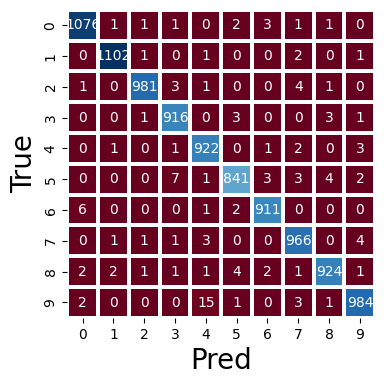

In [4]:
def compute_performance(net, loader):
    pred_list = torch.zeros(0)
    tgts_list = torch.zeros(0)
    top1_list = torch.zeros(0)
    top3_list = torch.zeros(0)
    
    net = net.to(torch.device("cpu"))
    net.eval()
    
    for idx, (imgs, tgts, _) in enumerate(v_loader):
        tgts_list = torch.cat((tgts_list, tgts), 0)
        pred_list = torch.cat((pred_list, net.get_max(imgs)), 0)
        top1_list = torch.cat((top1_list, net.get_topk(imgs, 1)), 0)
        top3_list = torch.cat((top3_list, net.get_topk(imgs, 3)), 0)
    
    top1_cnt = 0
    for tgt, t1 in zip(tgts_list, top1_list):
        if tgt in t1:
            top1_cnt += 1

    top3_cnt = 0
    for tgt, t3 in zip(tgts_list, top3_list):
        if tgt in t3:
            top3_cnt += 1

    correct = torch.where(tgts_list==pred_list, 1, 0)
    accm = correct.sum().item()
    tot = len(correct)

    acc = 100. * accm/tot
    top1 = 100. * top1_cnt/tot
    top3 = 100. * top3_cnt/tot
    confusion = confusion_matrix(tgts_list.numpy(), pred_list.numpy())
    
    return acc, top1, top3, confusion

acc, top1, top3, confusion = compute_performance(bignet, v_loader)

print("Top-1 Acc: {:.2f}%".format(top1))
print("Top-3 Acc: {:.2f}%".format(top3))
plt.figure(figsize=(7,4))
sns.heatmap(confusion,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
plt.xlabel("Pred",fontsize=20)
plt.ylabel("True",fontsize=20)
plt.show()

## step5. 顯示有多少參數，計算 $top_{1}/(\text{number of parameters})$

In [5]:
_, top1, _, _ = compute_performance(smallnet, v_loader)

print("Number fo parameters, {}".format(smallnet.count_parameters()))
print("Top-1 Acc: {:.2f}%".format(top1))
print("Top1/Params=: {:.8f}".format(0.01 * top1/smallnet.count_parameters()))

Number fo parameters, 2352
Top-1 Acc: 96.88%
Top1/Params=: 0.00041190


## step6. 預測 HW2_MNIST_test.zup 的資料

In [6]:
import pandas as pd
import io

loader = LazyLoader(TEST_DIR)
pred_result = list()
for _, (imgs, tgts, path) in enumerate(loader):
    filename = path[0][len(TEST_DIR)+1:] + ".png"
    pred = bignet.get_max(imgs)[0].item()
    pred_result.append((filename, pred))
pred_result = sorted(pred_result, key=lambda x: x[0])

csv_result = "image,class\n"
for _, (filename, pred) in enumerate(pred_result):
    csv_result += "{},{}\n".format(filename, pred)

csv_result = csv_result[:-1]
df = pd.read_csv(io.StringIO(csv_result), sep=",", header=None)
print(df)

with open("HW2_prob1.csv", "w") as f:
    f.write(csv_result)

                 0      1
0            image  class
1      0000004.png      0
2      0000010.png      0
3      0000018.png      0
4      0000021.png      0
...            ...    ...
24346  0121727.png      9
24347  0121730.png      9
24348  0121736.png      9
24349  0121738.png      9
24350  0121739.png      9

[24351 rows x 2 columns]
